In [85]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.impute import SimpleImputer
import sys
import os
import warnings

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf

import sklearn
import skforecast
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import  HistGradientBoostingRegressor, RandomForestRegressor
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.model_selection_multiseries import select_features_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from datetime import timedelta
from lightgbm import LGBMRegressor

warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

Version skforecast: 0.13.0
Version scikit-learn: 1.5.2
Version pandas: 2.2.3
Version numpy: 1.26.4


## Loading meme data

In [86]:
data = pd.read_csv('../data/processed/meme.csv')

print(data.shape)
data.head()

(33039, 10)


,timestamp,open,high,low,close,volume,name,symbol,id,category
0,1681689600,3.141154e-08,7.951914e-08,2.818250e-08,6.526480e-08,9.040237e+06,Pepe,PEPE,02e9c2cc-2e3b-45fe-b7bb-508cb23a3a39,meme
1,1681776000,6.485267e-08,2.276132e-07,5.598800e-08,1.878306e-07,3.246056e+07,Pepe,PEPE,02e9c2cc-2e3b-45fe-b7bb-508cb23a3a39,meme
2,1681862400,1.862740e-07,3.796318e-07,1.379781e-07,2.647504e-07,5.639813e+07,Pepe,PEPE,02e9c2cc-2e3b-45fe-b7bb-508cb23a3a39,meme
3,1681948800,2.648534e-07,4.051020e-07,2.291480e-07,2.945193e-07,4.044670e+07,Pepe,PEPE,02e9c2cc-2e3b-45fe-b7bb-508cb23a3a39,meme
4,1682035200,2.949180e-07,3.114699e-07,1.605779e-07,1.985193e-07,3.242627e+07,Pepe,PEPE,02e9c2cc-2e3b-45fe-b7bb-508cb23a3a39,meme


In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33039 entries, 0 to 33038
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  33039 non-null  int64  
 1   open       33039 non-null  float64
 2   high       33039 non-null  float64
 3   low        33039 non-null  float64
 4   close      33039 non-null  float64
 5   volume     33039 non-null  float64
 6   name       33039 non-null  object 
 7   symbol     33039 non-null  object 
 8   id         33039 non-null  object 
 9   category   33039 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 2.5+ MB


## Preprocessing data

In [88]:
def removing_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    duplicates = pd.read_csv('../data/raw/duplicates.csv')
    for index, row in duplicates.iterrows():
        id = row['id']
        category = row['category']
        df = df[~((df['id'] == id) & (df['category'] == category))]
    return df

In [89]:
data_cleaned = removing_duplicates(data)

### Capping time series

Capping the first timestamp of each token with the most common one in order to avoid error when predicting.

In [90]:
def capping_time_series(df: pd.DataFrame) -> pd.DataFrame:
    token_info = df.groupby('id')['name'].value_counts()
    mean = np.floor(token_info.mean()).astype(int)
    ids_to_keep = token_info[token_info > 365].index.get_level_values(0).unique()
    filtered_meme = df[df['id'].isin(ids_to_keep)]
    first_timestamps = filtered_meme.groupby('id').timestamp.min()
    last_timestamps = filtered_meme.groupby('id').timestamp.max()
    max_first_timestamp = first_timestamps.max()
    min_last_timestamp = last_timestamps.min()
    return filtered_meme[filtered_meme['timestamp'] <= min_last_timestamp]

In [91]:
data_capped = capping_time_series(data_cleaned)

In [92]:
# check how many tokens left
tokens = data_cleaned.groupby('id')['name'].value_counts()
tokens.describe()

count      33.000000
mean      990.424242
std       637.872785
min        97.000000
25%       534.000000
50%      1051.000000
75%      1267.000000
max      3701.000000
Name: count, dtype: float64

In [93]:
def timestamp_to_datetime(df: pd.DataFrame) -> pd.DataFrame:
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    return df

In [94]:
data_datetime = timestamp_to_datetime(data_capped)

In [95]:
# reset the index
data_datetime.reset_index(drop=True, inplace=True)
data_datetime.head()

,timestamp,open,high,low,close,volume,name,symbol,id,category
0,2023-04-17,3.141154e-08,7.951914e-08,2.818250e-08,6.526480e-08,9.040237e+06,Pepe,PEPE,02e9c2cc-2e3b-45fe-b7bb-508cb23a3a39,meme
1,2023-04-18,6.485267e-08,2.276132e-07,5.598800e-08,1.878306e-07,3.246056e+07,Pepe,PEPE,02e9c2cc-2e3b-45fe-b7bb-508cb23a3a39,meme
2,2023-04-19,1.862740e-07,3.796318e-07,1.379781e-07,2.647504e-07,5.639813e+07,Pepe,PEPE,02e9c2cc-2e3b-45fe-b7bb-508cb23a3a39,meme
3,2023-04-20,2.648534e-07,4.051020e-07,2.291480e-07,2.945193e-07,4.044670e+07,Pepe,PEPE,02e9c2cc-2e3b-45fe-b7bb-508cb23a3a39,meme
4,2023-04-21,2.949180e-07,3.114699e-07,1.605779e-07,1.985193e-07,3.242627e+07,Pepe,PEPE,02e9c2cc-2e3b-45fe-b7bb-508cb23a3a39,meme


### Scaling

In [96]:
def scaling(df: pd.DataFrame) -> pd.DataFrame:
    series_scaler = StandardScaler()
    exog_scaler = StandardScaler()
    halving_dates = [pd.to_datetime('2012-11-28'), pd.to_datetime('2016-07-09'), pd.to_datetime('2020-05-11'), pd.to_datetime('2024-04-20'), pd.to_datetime('2028-03-28')]
    df['days_until_halving'] = df['timestamp'].apply(lambda x: min([(halving - x).days for halving in halving_dates if halving > x]) if any(halving > x for halving in halving_dates) else 0).astype('float64')
    df['close'] = series_scaler.fit_transform(df[['close']])
    df['days_until_halving'] = exog_scaler.fit_transform(df[['days_until_halving']])
    return df, series_scaler, exog_scaler

In [97]:
data_final, series_scaler, exog_scaler = scaling(data_datetime)

In [98]:
# SHOW NUMBER UNIQUE TOKENS
data_final['id'].nunique()

27

In [99]:
# create a function to plot the time series of each token in a loop
def plot_time_series(df: pd.DataFrame, n: int) -> None:
    ids = df['id'].unique()
    for i in range(n):
        id = ids[i]
        token = df[df['id'] == id]
        plt.figure(figsize=(15, 5))
        plt.plot(token['timestamp'], token['close'])
        plt.title(f'Token ID: {id}')
        plt.show()

In [100]:
# plot_time_series(meme, 20)

In [101]:
def create_series_exog(df: pd.DataFrame) -> pd.DataFrame:
    data_copy = df.copy()
    data_copy['seconds'] = data_copy['timestamp'].apply(lambda x: x.timestamp())
    
    day = 60 * 60 * 24
    week = day * 7
    month = week * 4

    data_copy['week_sin'] = np.sin(data_copy['seconds'] * (2 * np.pi / week))
    data_copy['week_cos'] = np.cos(data_copy['seconds'] * (2 * np.pi / week))
    data_copy['month_sin'] = np.sin(data_copy['seconds'] * (2 * np.pi / month))
    data_copy['month_cos'] = np.cos(data_copy['seconds'] * (2 * np.pi / month))

    series = data_copy[['timestamp', 'id', 'close']]
    exog = data_copy[['timestamp', 'id', 'days_until_halving']]
    return series, exog

def create_future_exog(df: pd.DataFrame, days: int = 60) -> pd.DataFrame:
    last_timestamp = df['timestamp'].max()
    future_dates = pd.date_range(start=last_timestamp + timedelta(days=1), periods=days, freq='D')
    
    future_data = pd.DataFrame({'timestamp': future_dates})
    future_data['seconds'] = future_data['timestamp'].apply(lambda x: x.timestamp())

    day = 60 * 60 * 24
    week = day * 7
    month = week * 4

    future_data['week_sin'] = np.sin(future_data['seconds'] * (2 * np.pi / week))
    future_data['week_cos'] = np.cos(future_data['seconds'] * (2 * np.pi / week))
    future_data['month_sin'] = np.sin(future_data['seconds'] * (2 * np.pi / month))
    future_data['month_cos'] = np.cos(future_data['seconds'] * (2 * np.pi / month))

    # Assuming 'id' remains the same for future data
    future_data['id'] = df['id'].iloc[0]

    halving_dates = [pd.to_datetime('2012-11-28'), pd.to_datetime('2016-07-09'), pd.to_datetime('2020-05-11'), pd.to_datetime('2024-04-20'), pd.to_datetime('2028-03-28')]
    future_data['days_until_halving'] = future_data['timestamp'].apply(lambda x: min([(halving - x).days for halving in halving_dates if halving > x]) if any(halving > x for halving in halving_dates) else 0).astype('float64')
    

    exog_future = future_data[['timestamp', 'id', 'days_until_halving']]
    exog_future.loc[:, 'days_until_halving'] = exog_scaler.transform(exog_future[['days_until_halving']])
    return exog_future

def create_all_future_exog(df: pd.DataFrame, days: int = 60) -> pd.DataFrame:
    future_exog_list = []
    
    for id, group in df.groupby('id'):
        future_exog = create_future_exog(group, days)
        future_exog_list.append(future_exog)
    
    all_future_exog = pd.concat(future_exog_list, ignore_index=True)
    return all_future_exog

In [102]:
series, exog = create_series_exog(data_final)
future_exog = create_all_future_exog(data_final, days=7)

In [103]:
series_dict = series_long_to_dict(
                 data=series, 
                 series_id='id', 
                 index='timestamp', 
                 values= 'close', 
                 freq='D')

exog_dict = exog_long_to_dict(
    data      = exog,
    series_id = 'id',
    index     = 'timestamp',
    freq      = 'D'
)

future_exog_dict = exog_long_to_dict(
    data      = future_exog,
    series_id = 'id',
    index     = 'timestamp',
    freq      = 'D'
)

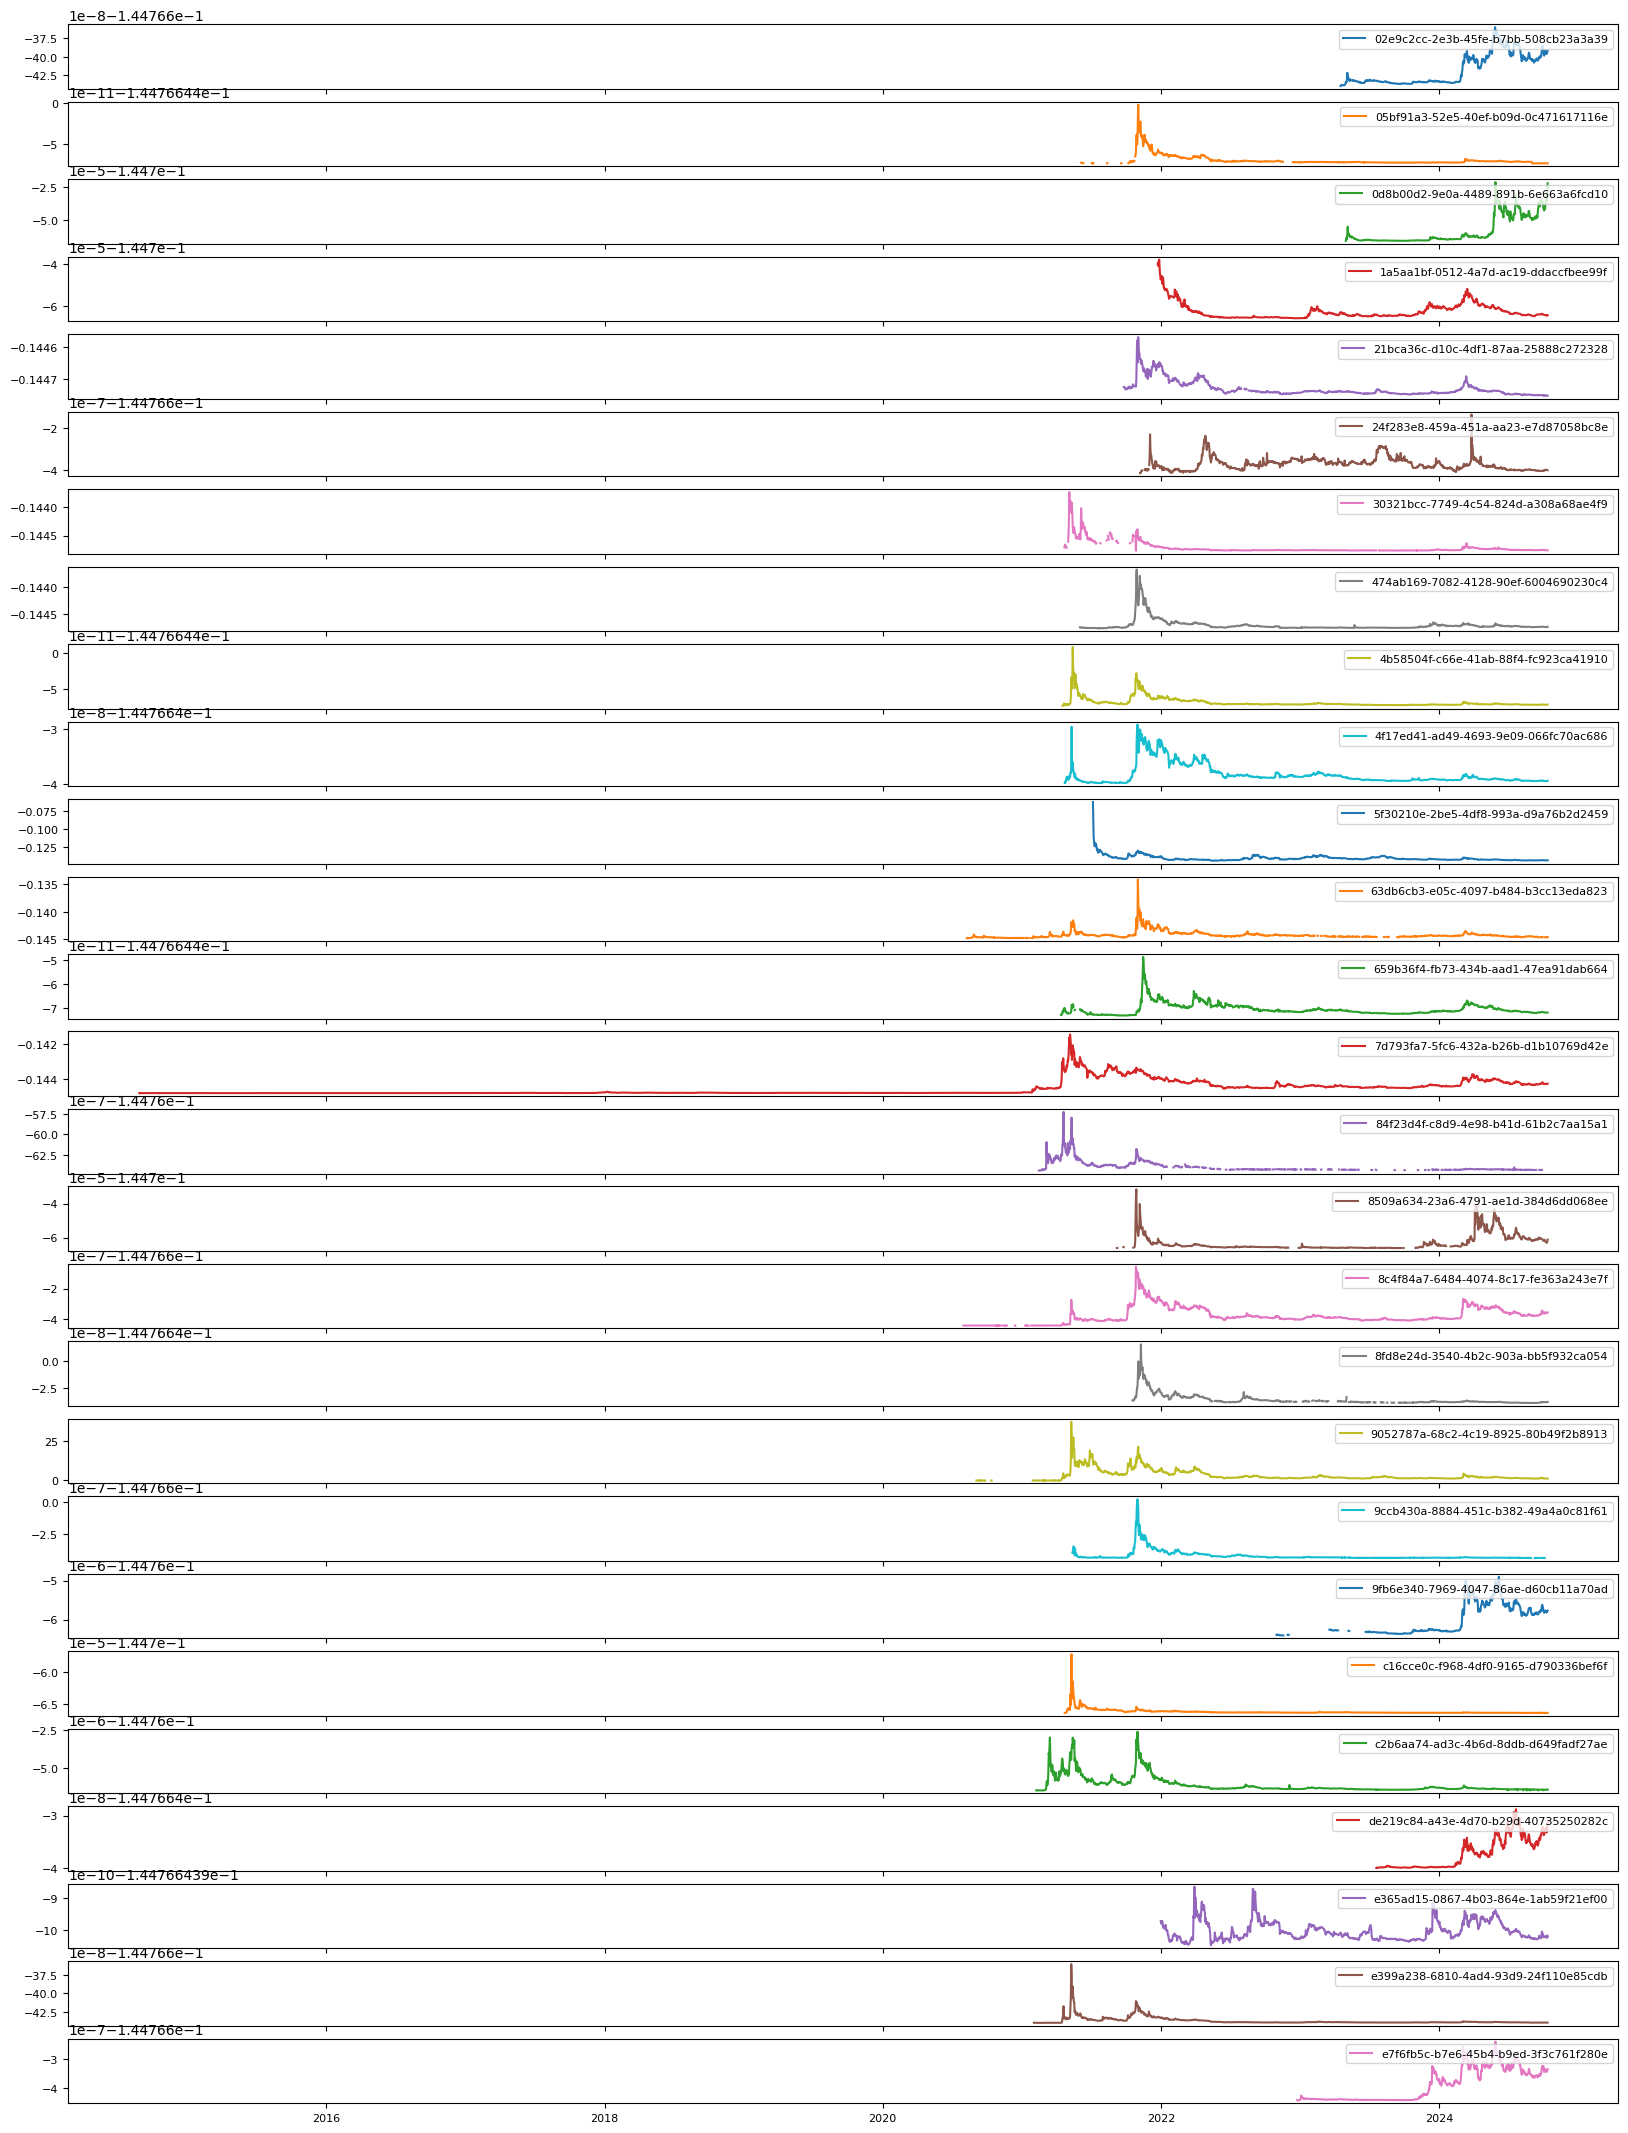

In [104]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
num_tokens = len(series_dict)
# Ensure there are enough colors
if len(colors) < num_tokens:
    colors = colors * (len(series_dict) // len(colors) + 1)
fig, axs = plt.subplots(num_tokens, 1, figsize=(20, num_tokens), sharex=True)
for i, s in enumerate(series_dict.values()):
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

In [105]:
def train_forecaster(series_dict: dict, exog_dict: exog_long_to_dict) -> ForecasterAutoregMultiSeries:
    regressor = LGBMRegressor(random_state=123, max_depth=5)
    forecaster = ForecasterAutoregMultiSeries(
                    regressor          = regressor,
                    lags               = 10,
                    encoding           = "ordinal",
                    dropna_from_series = False
                )
    
    forecaster.fit(series=series_dict, exog=exog_dict,suppress_warnings=True)
    
    return forecaster

In [106]:
forecaster = train_forecaster(series_dict, exog_dict)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2832
[LightGBM] [Info] Number of data points in the train set: 30900, number of used features: 12
[LightGBM] [Info] Start training from score 0.001098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [107]:
def predict_X_days(days_to_predict: int, future_exog_dict: exog_long_to_dict) -> pd.DataFrame:
    return forecaster.predict(steps=days_to_predict, exog=future_exog_dict, suppress_warnings=True)

In [108]:
predictions = predict_X_days(7, future_exog_dict)

In [109]:
predictions.head()

,02e9c2cc-2e3b-45fe-b7bb-508cb23a3a39,05bf91a3-52e5-40ef-b09d-0c471617116e,0d8b00d2-9e0a-4489-891b-6e663a6fcd10,1a5aa1bf-0512-4a7d-ac19-ddaccfbee99f,21bca36c-d10c-4df1-87aa-25888c272328,24f283e8-459a-451a-aa23-e7d87058bc8e,30321bcc-7749-4c54-824d-a308a68ae4f9,474ab169-7082-4128-90ef-6004690230c4,4b58504f-c66e-41ab-88f4-fc923ca41910,4f17ed41-ad49-4693-9e09-066fc70ac686,...,8fd8e24d-3540-4b2c-903a-bb5f932ca054,9052787a-68c2-4c19-8925-80b49f2b8913,9ccb430a-8884-451c-b382-49a4a0c81f61,9fb6e340-7969-4047-86ae-d60cb11a70ad,c16cce0c-f968-4df0-9165-d790336bef6f,c2b6aa74-ad3c-4b6d-8ddb-d649fadf27ae,de219c84-a43e-4d70-b29d-40735250282c,e365ad15-0867-4b03-864e-1ab59f21ef00,e399a238-6810-4ad4-93d9-24f110e85cdb,e7f6fb5c-b7e6-45b4-b9ed-3f3c761f280e
2024-10-13,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581,...,-0.144581,1.148926,-0.144549,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581
2024-10-14,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581,...,-0.144581,1.148926,-0.144570,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581,-0.144581
2024-10-15,-0.144564,-0.144564,-0.144564,-0.144564,-0.144564,-0.144564,-0.144564,-0.144564,-0.144564,-0.144564,...,-0.144564,1.148926,-0.144556,-0.144564,-0.144564,-0.144564,-0.144564,-0.144564,-0.144564,-0.144564
2024-10-16,-0.144539,-0.144539,-0.144539,-0.144539,-0.144539,-0.144539,-0.144539,-0.144539,-0.144539,-0.144539,...,-0.144539,1.148926,-0.144523,-0.144539,-0.144539,-0.144539,-0.144539,-0.144539,-0.144539,-0.144539
2024-10-17,-0.144514,-0.144514,-0.144514,-0.144514,-0.144514,-0.144514,-0.144514,-0.144514,-0.144514,-0.144514,...,-0.144514,1.148926,-0.144514,-0.144514,-0.144514,-0.144514,-0.144514,-0.144514,-0.144514,-0.144514


In [110]:
def plot_predictions(series_dict, predictions_x_days, last_data_points=0, max_coins=None):
    tokens = list(series_dict.keys())
    
    if max_coins:
        tokens = tokens[:max_coins]
    
    for token_id in tokens:
        historical_data = series_dict[token_id]
        
        # Determine the number of steps ahead (based on the prediction length)
        steps_ahead = len(predictions_x_days)
        
        # Create a timeline for the predictions (future dates after the last historical data point)
        last_date = historical_data.index[-1]
        future_dates = pd.date_range(start=last_date, periods=steps_ahead + 1, freq='D')[1:]  # Skip the last date
        
        # Get the predicted values for the token
        if token_id in predictions_x_days.columns:
            predictions = pd.Series(predictions_x_days[token_id], index=future_dates, name='Predictions')
        else:
            continue
        
        # Concatenate historical data with predictions
        combined_data = pd.concat([historical_data, predictions])
        
        # Get only the last `last_data_points` from historical data
        if last_data_points > 0:
            combined_data = combined_data[-last_data_points:]
        
        # Plot the data
        plt.figure(figsize=(20, 5))
        plt.plot(combined_data.index, combined_data, label='Historical + Predictions')
        plt.axvline(x=last_date, color='red', linestyle='--', label='Start of Predictions')
        plt.title(f'Token: {token_id} - Historical Data and {steps_ahead}-Day Forecast')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        
        # Display plot
        plt.show()

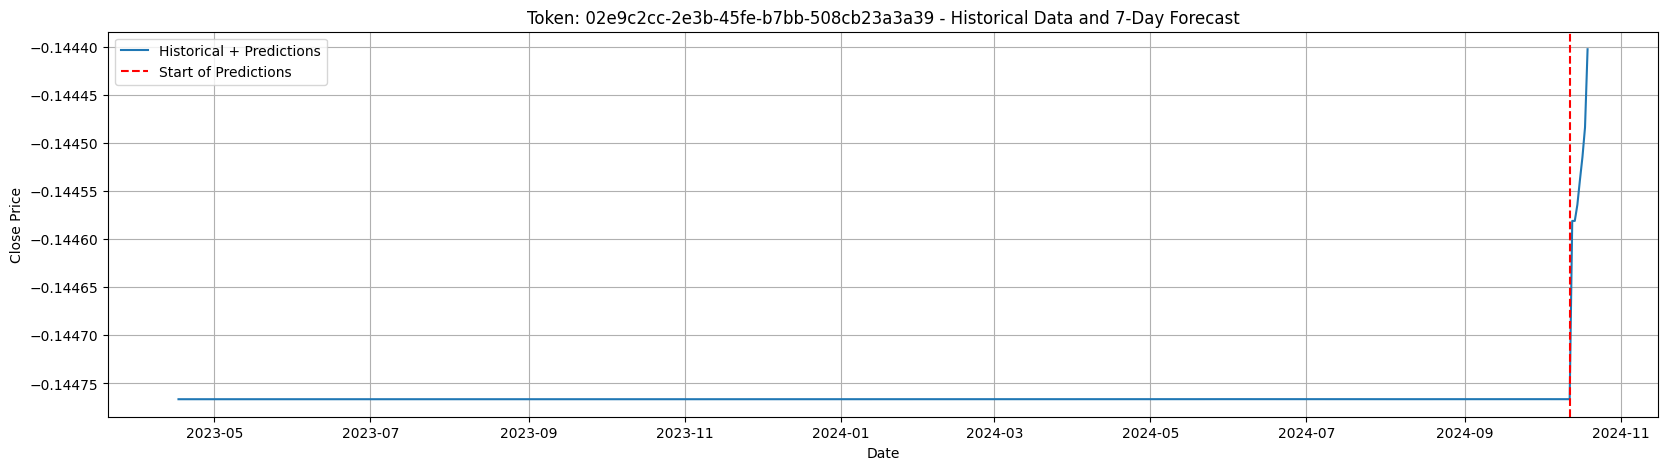

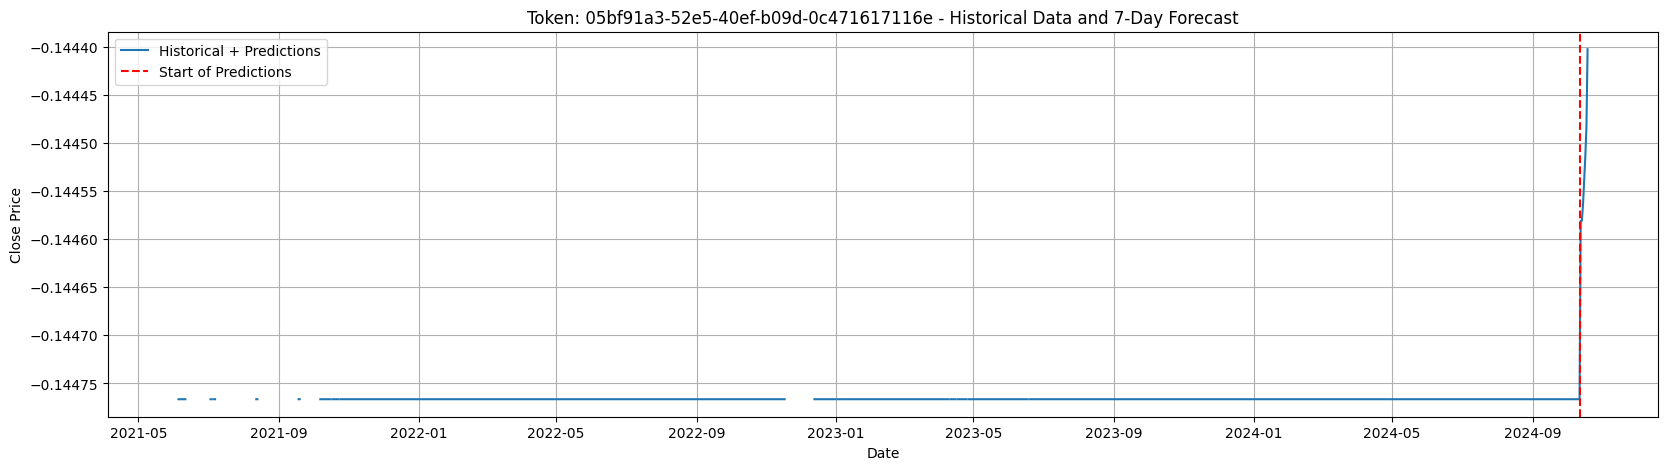

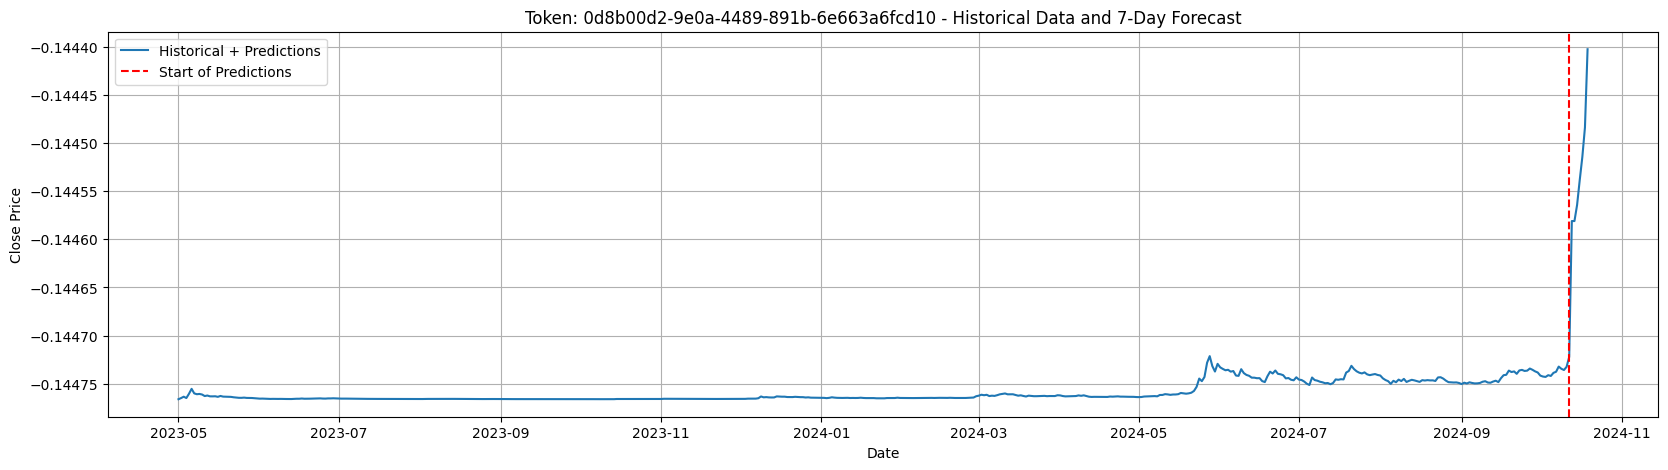

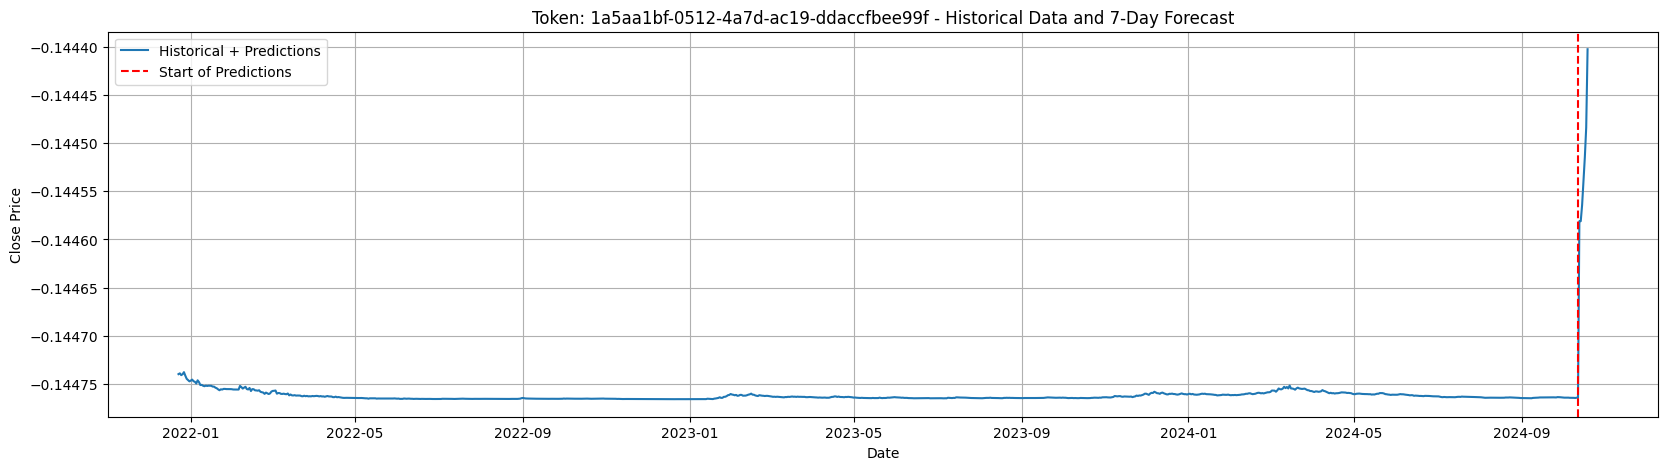

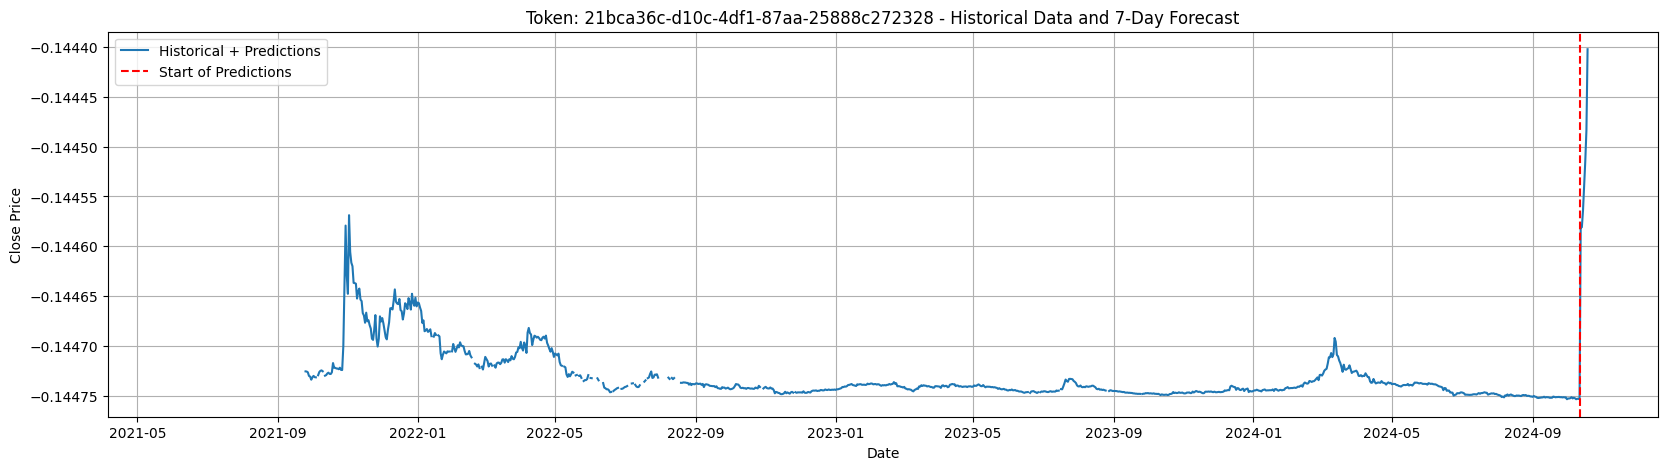

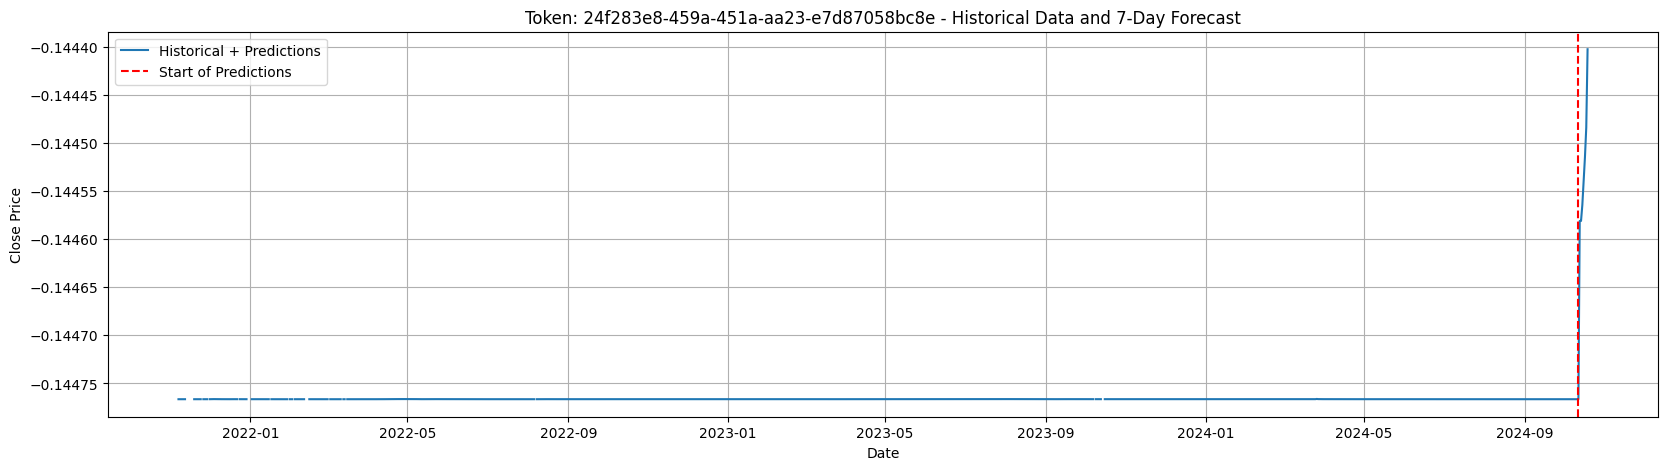

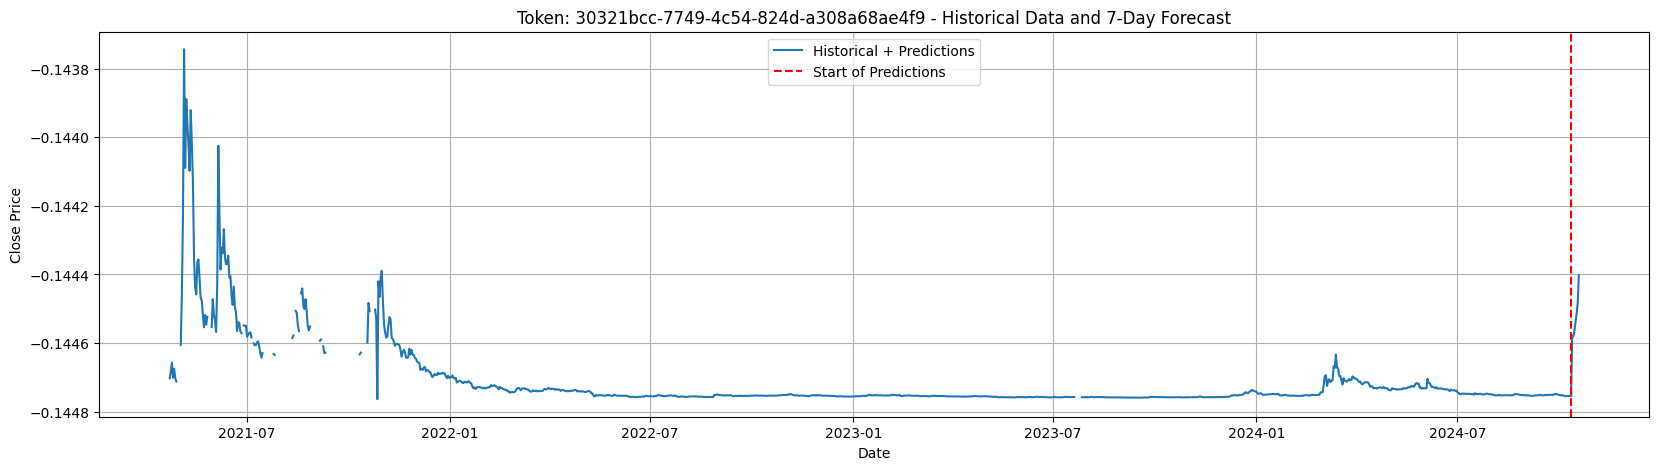

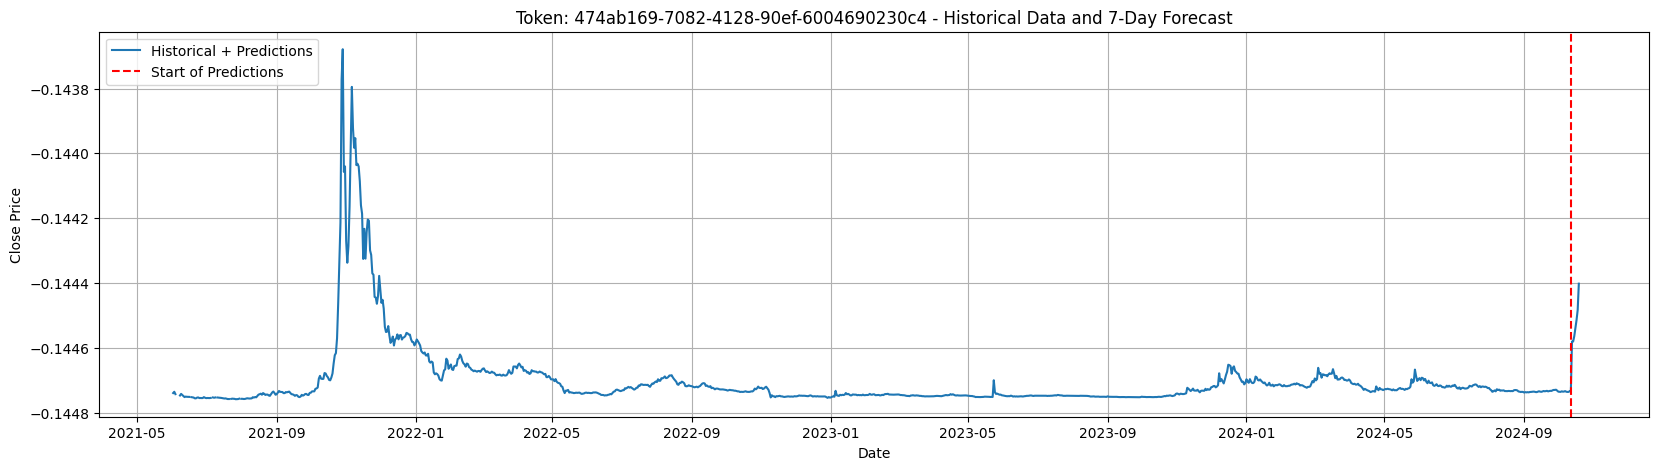

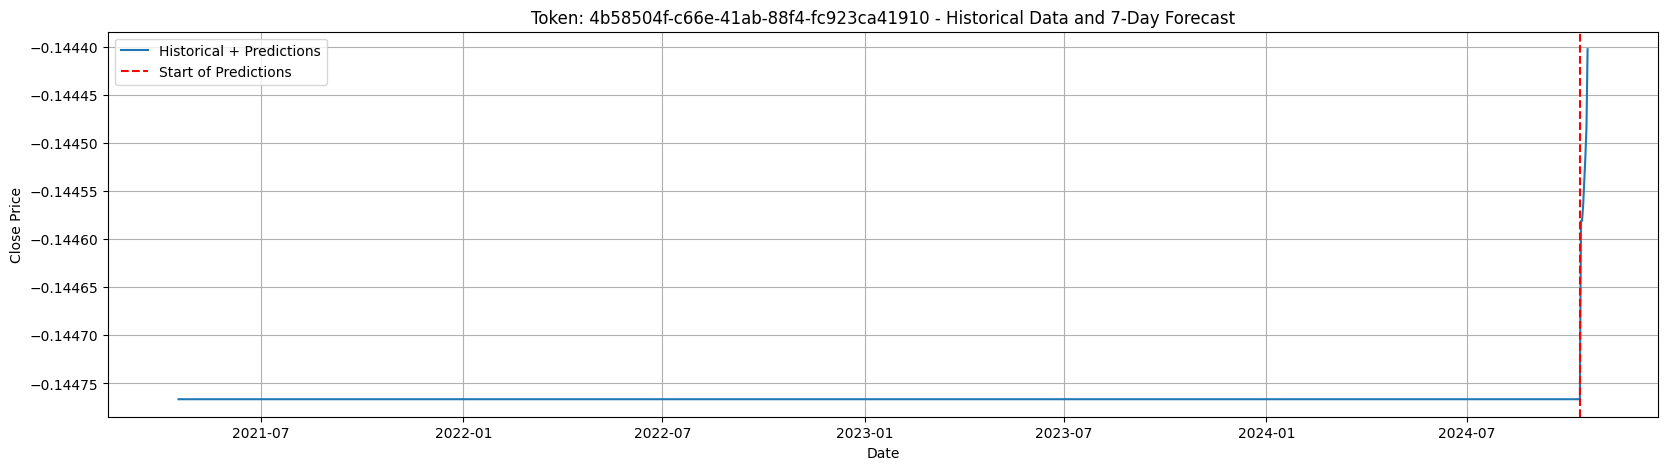

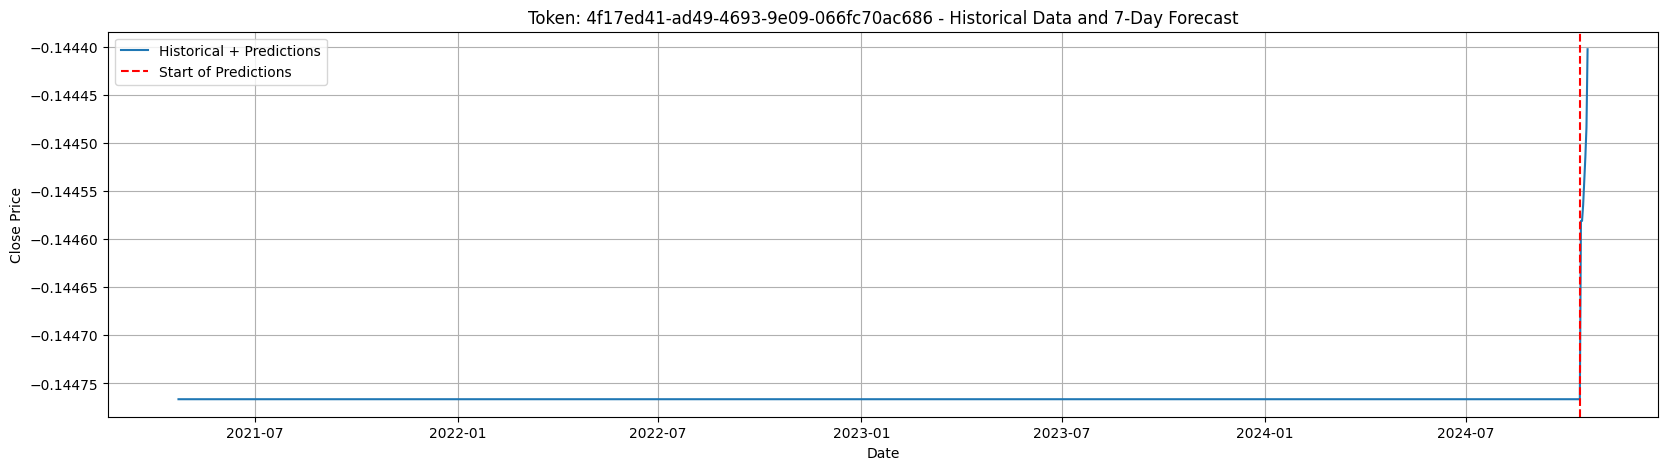

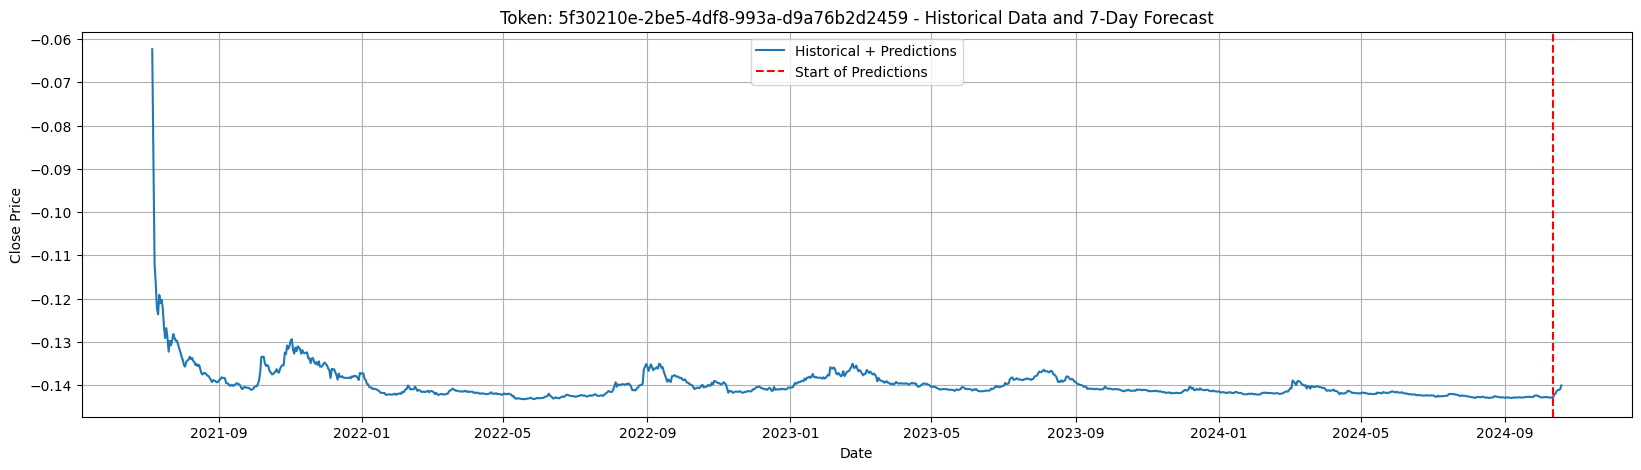

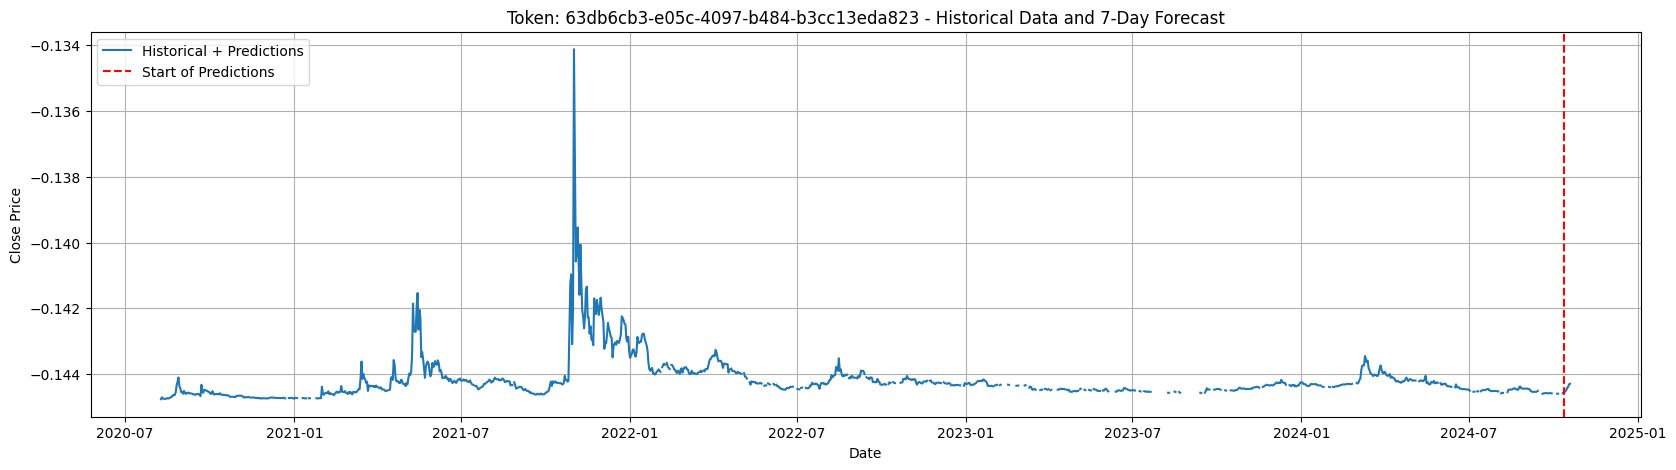

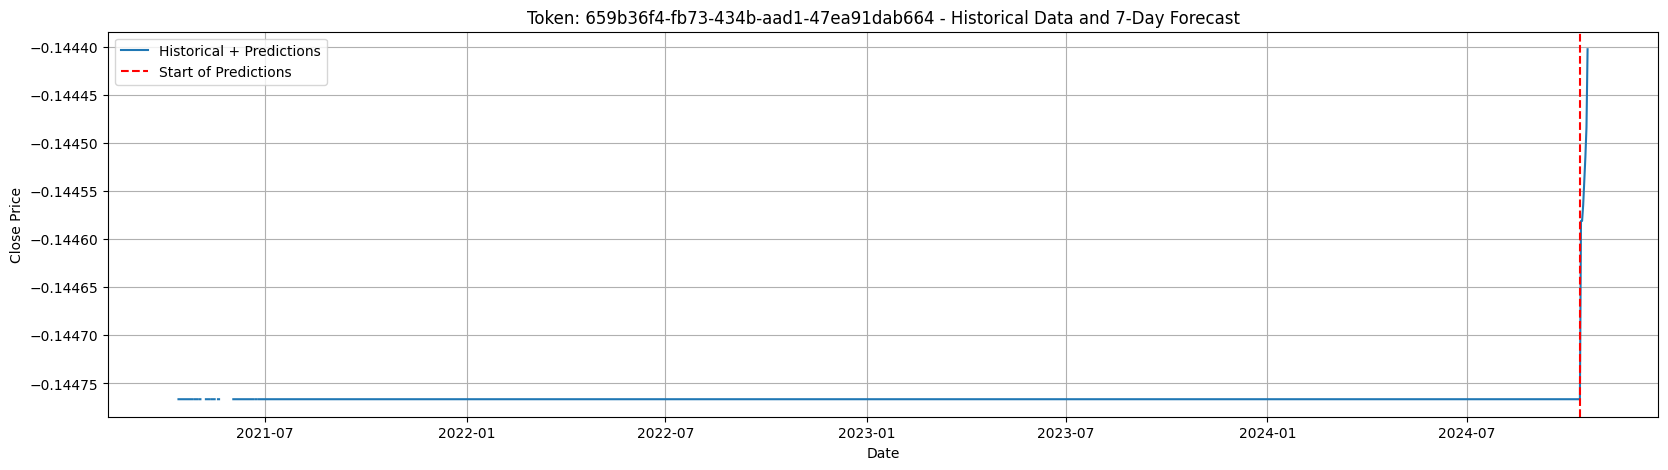

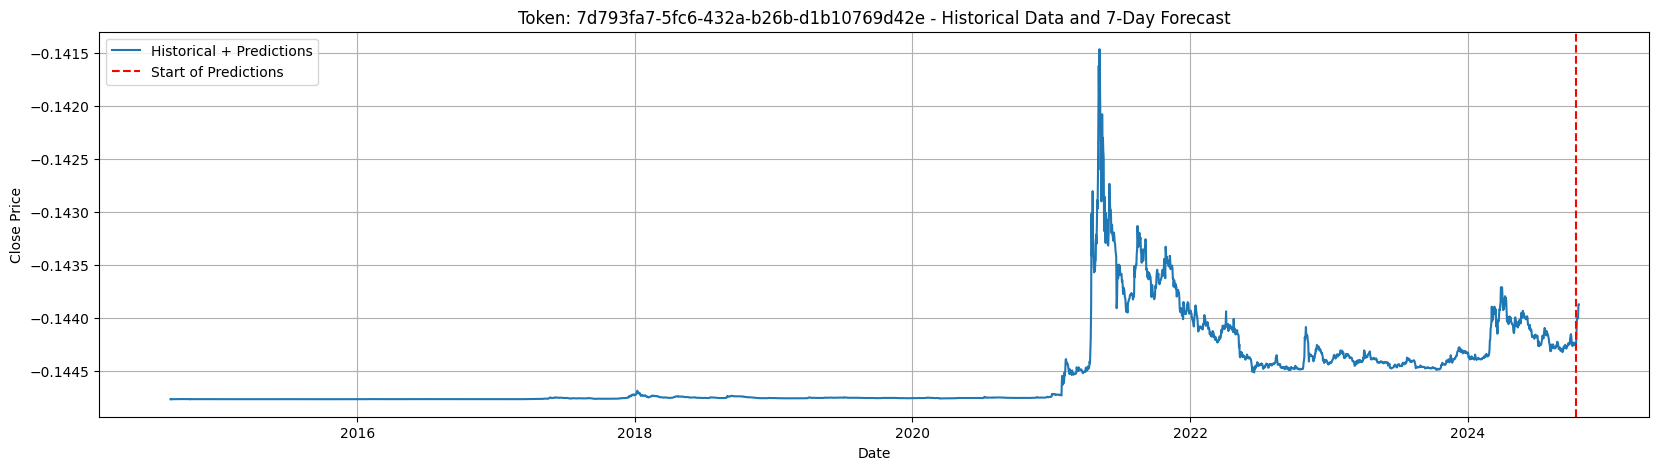

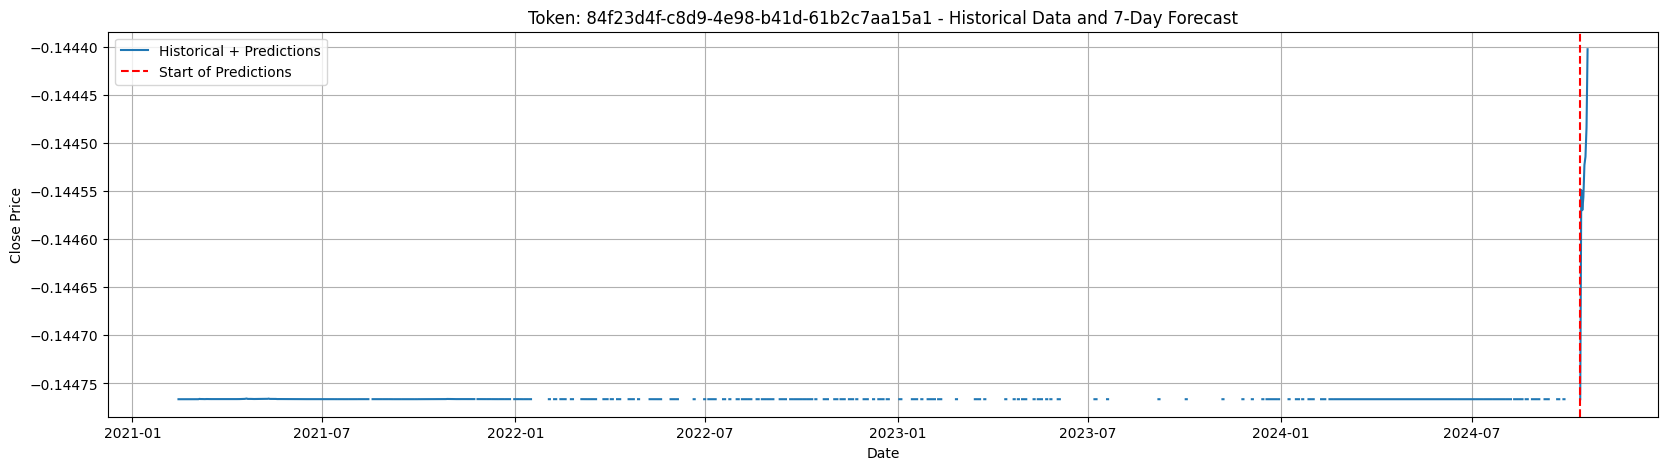

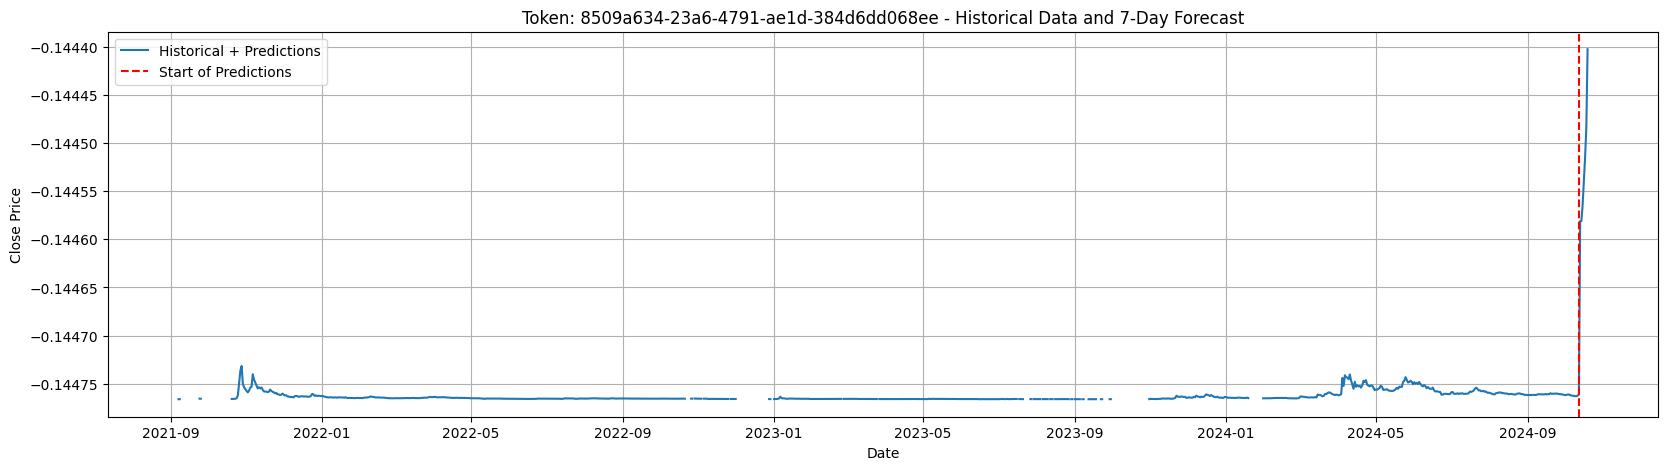

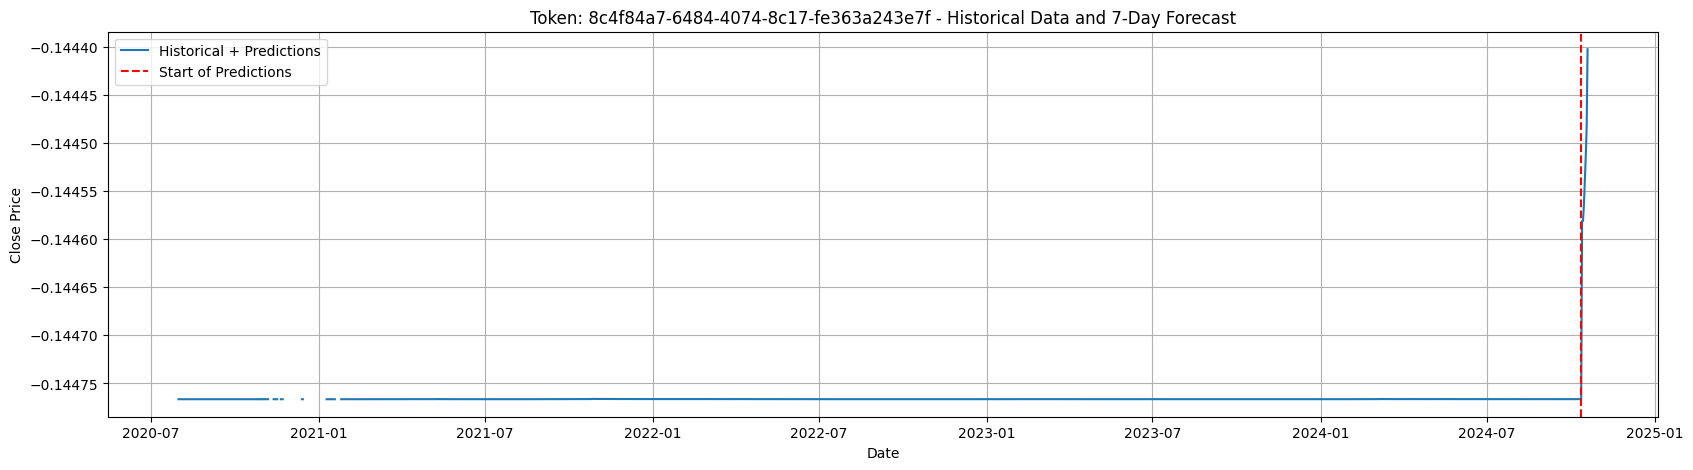

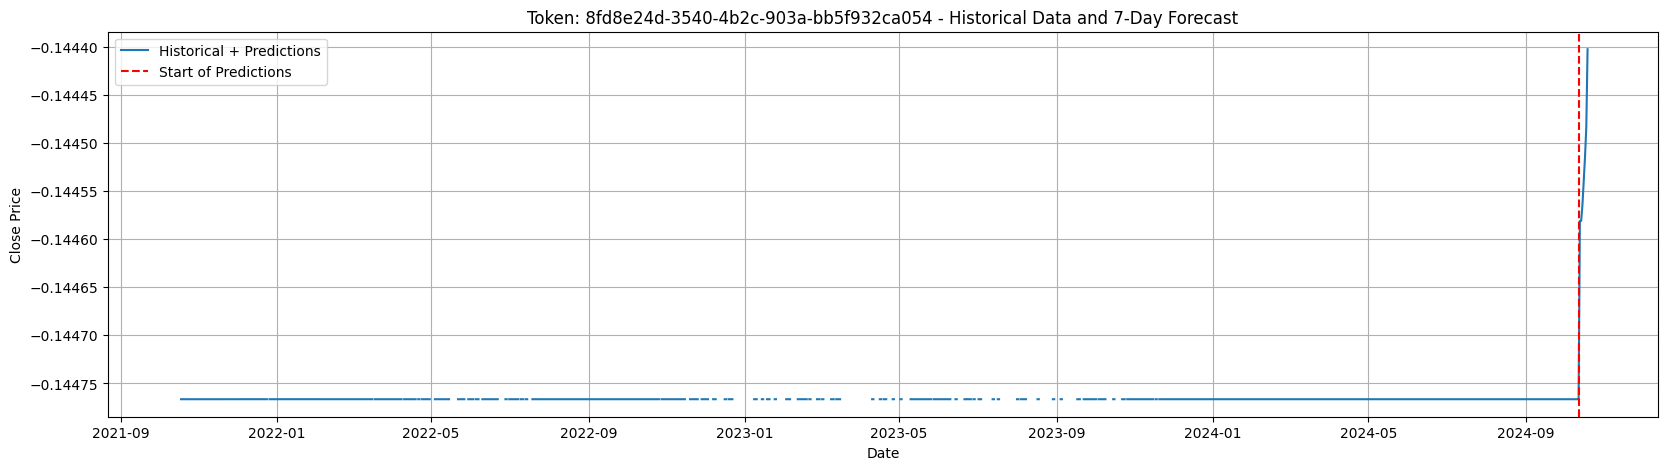

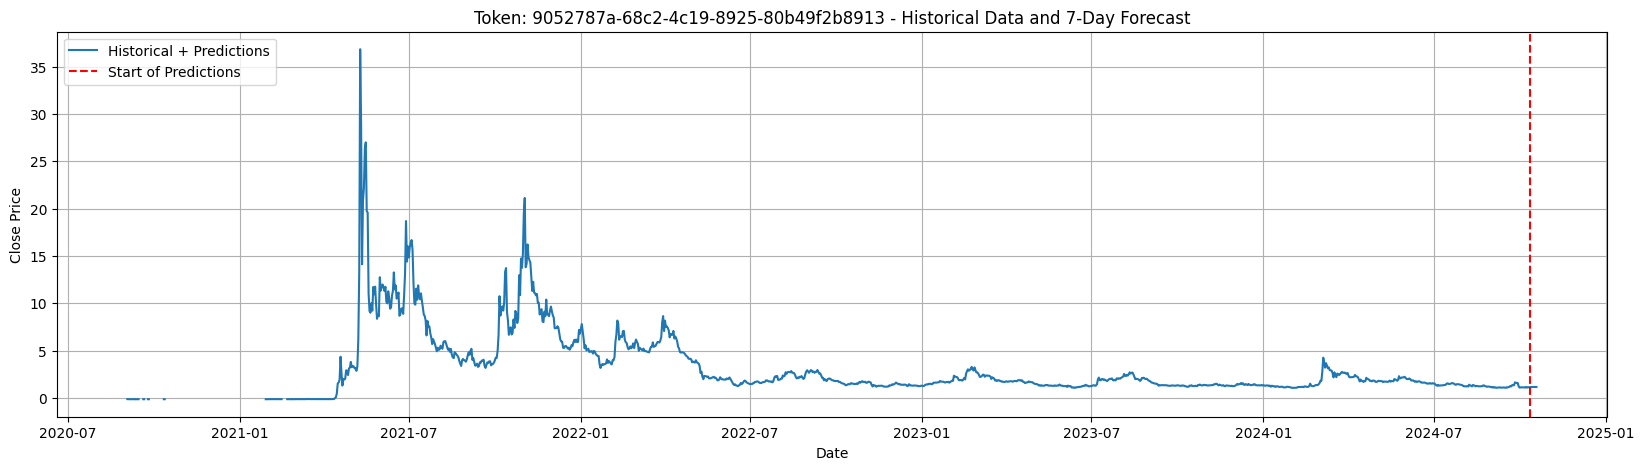

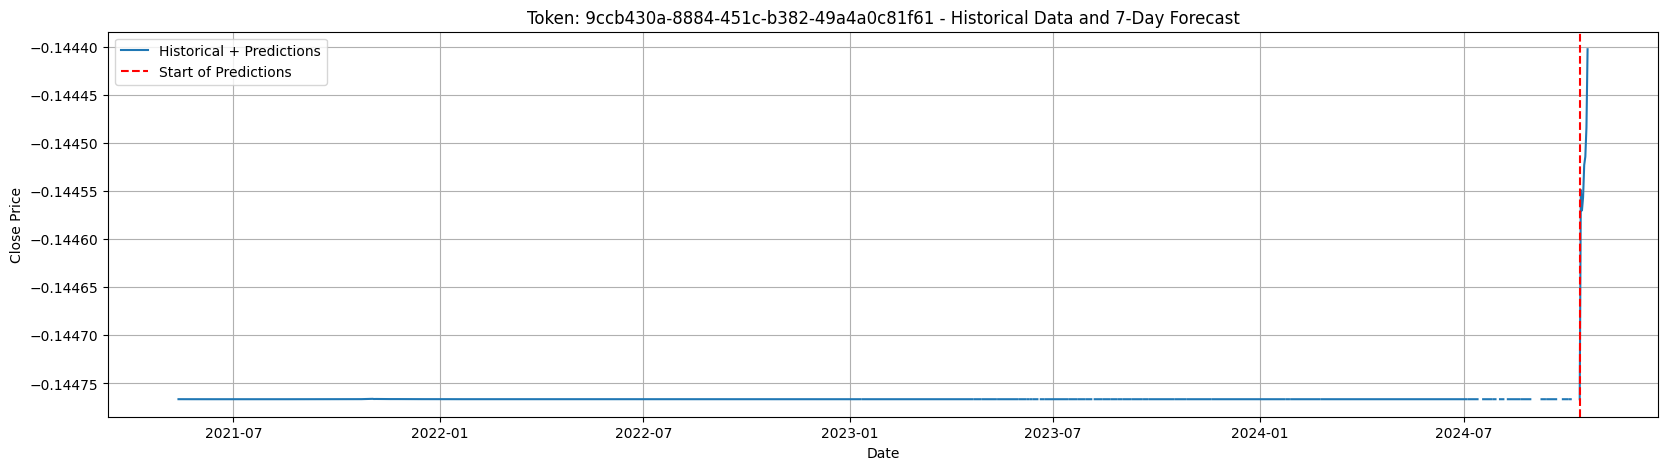

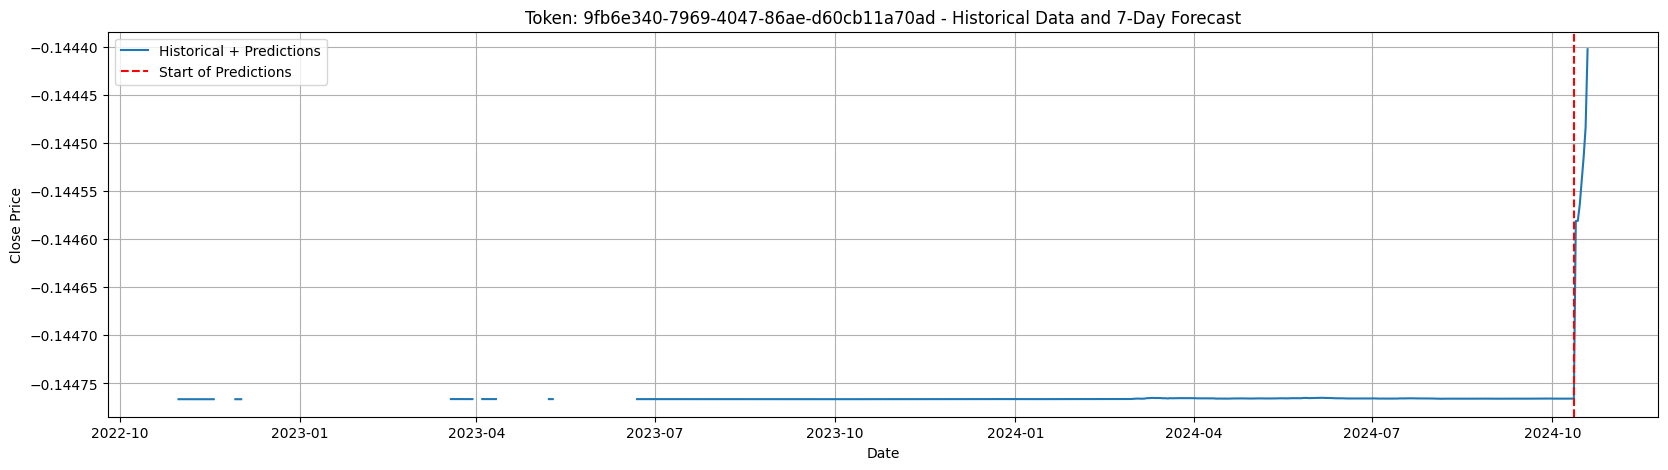

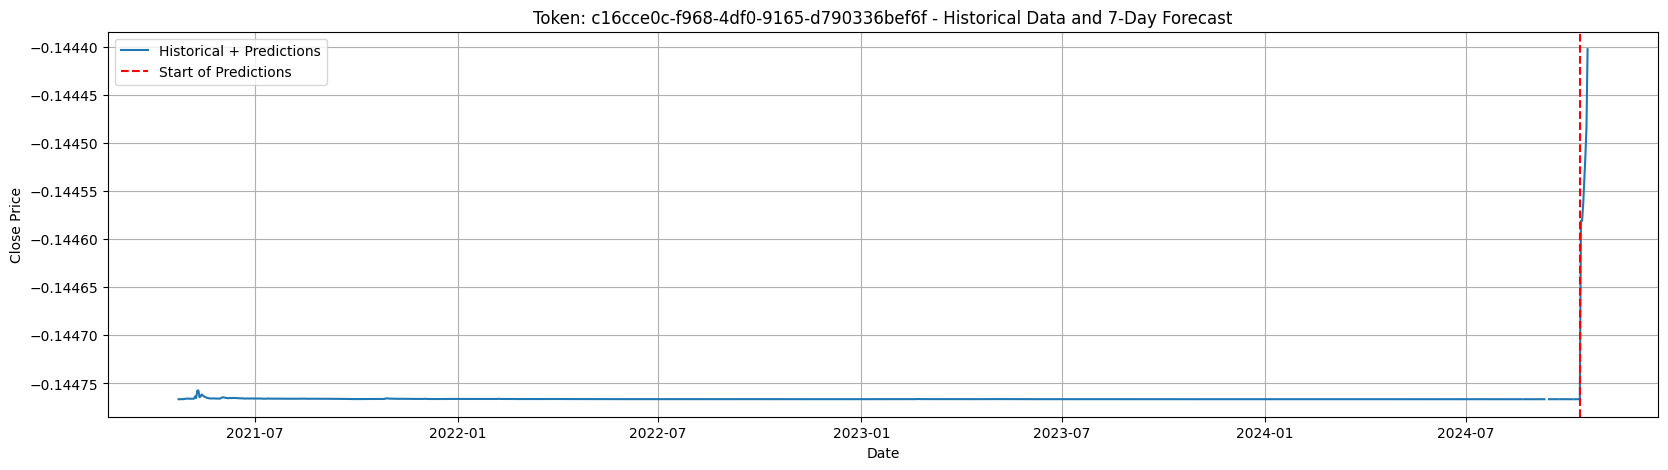

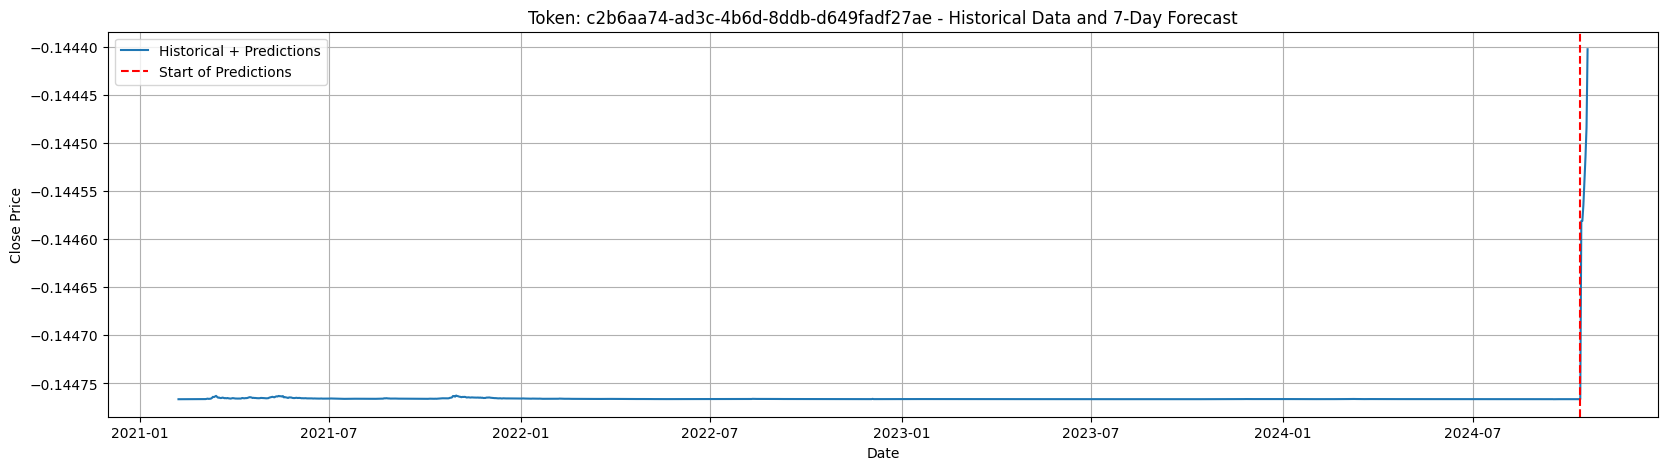

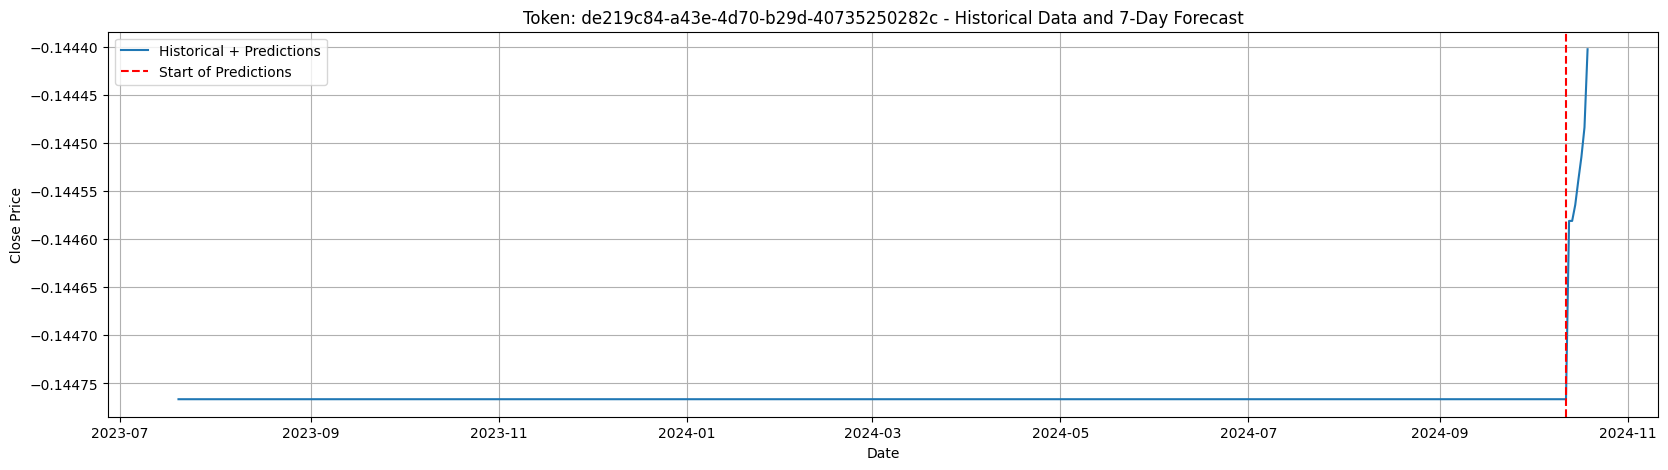

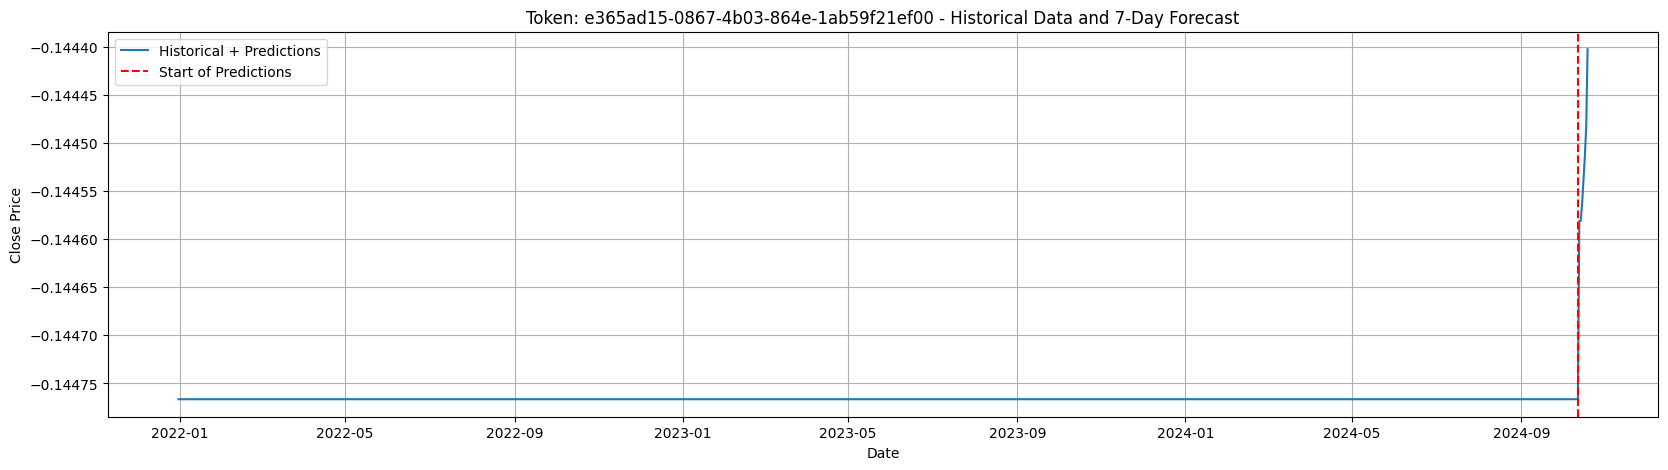

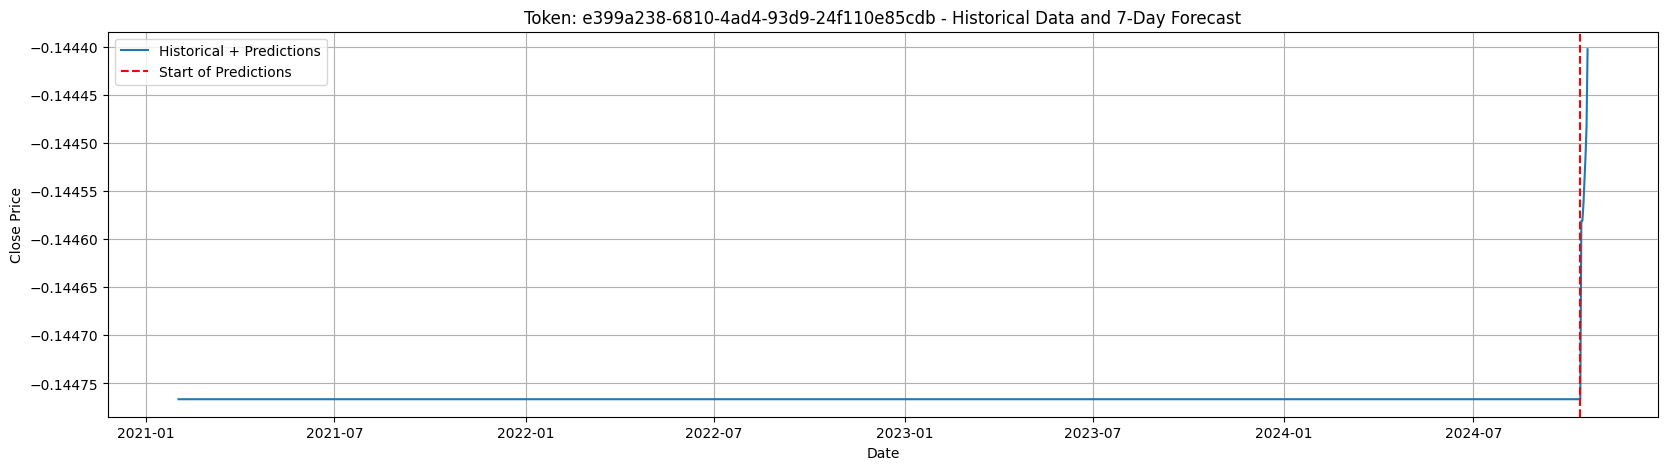

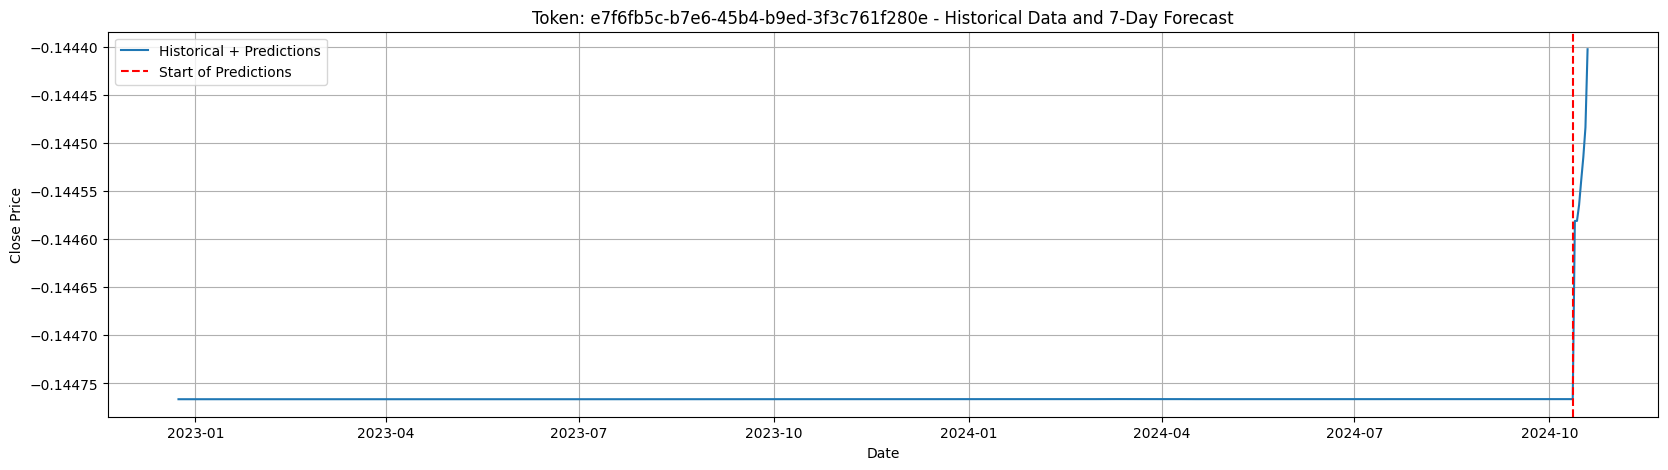

In [111]:
plot_predictions(series_dict, predictions, max_coins=50)